In [2]:
import json
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 14})

# top k scores

In [13]:
# get all relation label names in the dataset
def get_relns(dataset):
    relns = set()
    for example in dataset:
        for reln in example["relns"].keys():
            relns.add(reln)
    relns = list(relns)
    relns.sort()
    return relns


# average topk scores for each relationship and categories (word level)
def get_avg(scores, relns, max_k=20):
    reln_avg = [None]*(max_k+1)
    cat_avg = {}
    for cat, cat_relns in categories.items():
        cat_avg[cat] = [None]*(max_k+1)

    for k in range(1, (max_k+1)):
        sum, count = 0, 0
        for cat, cat_relns in categories.items():
            cat_sum, cat_count = 0, 0
            for cat_reln in cat_relns:
                for reln in relns:
                    if reln.startswith(cat_reln+":"):
                        flatten_idx = np.argmax(scores[reln][:,:,k])
                        num_head = scores[reln].shape[1]
                        row = int(flatten_idx/num_head)
                        col = flatten_idx % num_head
                        sum += scores[reln][row][col][k]
                        count += 1
                        cat_sum += scores[reln][row][col][k]
                        cat_count += 1
            cat_avg[cat][k] = cat_sum/cat_count
        reln_avg[k] = sum/count
    return (reln_avg, cat_avg)

def print_attn_table(k, relns, scores):
    print("relationship\t\t  accuracy\tlayer\thead")
    sum, count = 0, 0
    table = ""
    table2 = "category\t\t  average accuracy\n"
    for cat, cate_relns in categories.items():
        table += "===================" + cat.ljust(20,"=") + "==========\n"
        cate_sum, cate_count = 0, 0
        for cate_reln in cate_relns:
            for reln in relns:
                if reln.startswith(cate_reln+":"):
                    flatten_idx = np.argmax(scores[reln][:,:,k])
                    num_head = scores[reln].shape[1]
                    row = int(flatten_idx/num_head)
                    col = flatten_idx % num_head
                    table += reln.ljust(30) + str(round(scores[reln][row][col][k],3)).ljust(5) + "\t" + str(row) + "\t" + str(col) + '\n'
                    sum += scores[reln][row][col][k]
                    count += 1
                    cate_sum += scores[reln][row][col][k]
                    cate_count += 1
        table2 += cat.ljust(20) + "\t\t"+str(round(cate_sum/cate_count,3)) + "\n"
    print(table)
    print(table2)
    print("average of",count,"relations:", sum/count)
    
def print_baseline_table(k, relns, reln_scores_topk):
    print("relationship\t\t  accuracy\toffset")
    sum, count = 0, 0
    table = ""
    table2 = "category\t\t  average accuracy\n"
    for cat, cate_relns in categories.items():
        table += "===================" + cat.ljust(20,"=") + "==========\n"
        cate_sum, cate_count = 0, 0
        for cate_reln in cate_relns:
            for reln in relns:
                if reln.startswith(cate_reln+":"):
                    table += reln.ljust(30) + str(round(reln_scores_topk[reln][k][0],3)).ljust(5) + "\t" + str(reln_scores_topk[reln][k][1])[1:-1] + '\n'
                    sum += reln_scores_topk[reln][k][0]
                    count += 1
                    cate_sum += reln_scores_topk[reln][k][0]
                    cate_count += 1
        table2 += cat.ljust(20) + "\t\t"+str(round(cate_sum/cate_count,3)) + "\n"
    print(table)
    print(table2)
    print("average of",count,"relations:", sum/count)
    
def print_attn_baseline_table(k, relns, attn_scores, baseline_reln_scores_topk, diff=True, compare_k=-1):
    attn_sum, count, baseline_sum = 0, 0, 0
    table = "relationship\t\tattention\tbaseline\toffset"
    table2 = "category\t\tattention\tbaseline"
    if diff:
        table += "\tdifference"
        table2 += "\tdifference"
    if compare_k != -1:
        table += "\tdifference(k=" + str(compare_k) +")"
    for cat, cate_relns in categories.items():
        table += "\n=========================" + cat.ljust(20,"=") + "================"
        attn_cate_sum, cate_count, baseline_cate_sum = 0, 0, 0
        for cate_reln in cate_relns:
            for reln in relns:
                if reln.startswith(cate_reln+":"):
                    flatten_idx = np.argmax(attn_scores[reln][:,:,k])
                    num_head = attn_scores[reln].shape[1]
                    row = int(flatten_idx/num_head)
                    col = flatten_idx % num_head
                    table += ('\n' + reln.ljust(30) + str(round(attn_scores[reln][row][col][k],3)).ljust(5) 
                              + "\t" + str(round(baseline_reln_scores_topk[reln][k][0],3)).ljust(5) 
                              + "\t\t" + str(baseline_reln_scores_topk[reln][k][1])[1:-1])
                    if diff:
                        table += "\t" + str(round(attn_scores[reln][row][col][k]-baseline_reln_scores_topk[reln][k][0],3)).ljust(5) 
                    if compare_k != -1:
                        compare_flatten_idx = np.argmax(attn_scores[reln][:,:,compare_k])
                        compare_row = int(flatten_idx/num_head)
                        compare_col = flatten_idx % num_head
                        table += "\t\t" + str(round(attn_scores[reln][compare_row][compare_col][compare_k]-
                                                  baseline_reln_scores_topk[reln][compare_k][0],3)).ljust(5) 
                    attn_sum += attn_scores[reln][row][col][k]
                    baseline_sum += baseline_reln_scores_topk[reln][k][0]
                    count += 1
                    attn_cate_sum += attn_scores[reln][row][col][k]
                    baseline_cate_sum += baseline_reln_scores_topk[reln][k][0]
                    cate_count += 1
        table2 += ("\n" + cat.ljust(20) + "\t\t"+str(round(attn_cate_sum/cate_count,3)) + 
                   "\t"+str(round(baseline_cate_sum/cate_count,3)))
        if diff:
            table2 += "\t\t"+str(round(attn_cate_sum/cate_count-baseline_cate_sum/cate_count,3))
    print(table, "\n")
    print(table2)
    print("attention average of",count,"relations:", attn_sum/count)
    print("baseline average of",count,"relations:", baseline_sum/count)
    
    
# for baselines
def get_scores_topk(reln_scores_topk, max_k=20):
    scores_topk = [0]*(max_k+1)
    for k in range(1, max_k+1):
        sum, count = 0, 0
        for cat, cat_relns in categories.items():
            for cat_reln in cat_relns:
                for reln in relns:
                    if reln.startswith(cat_reln+":"):
                        sum += reln_scores_topk[reln][k][0]
                        count += 1
        scores_topk[k] = sum/count
    last = 0
    for i in range(0, max_k+1):
        if scores_topk[i] == 0:
            scores_topk[i] = last
        else:
            last = scores_topk[i]
    return scores_topk

# for combined baseline. Get maximum score of offset and keyword baseline.
def get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20):
    # replace 0 with the previous score
    for scores in [reln_scores_topk_offset, reln_scores_topk_keyword]:
        for key, value in scores.items():
            last = (0, [0])
            for i in range(0, max_k+1):
                if value[i][0] == 0:
                    value[i] = last
                last = value[i]
    
    scores_topk = [0]*(max_k+1)
    for k in range(1, max_k+1):
        sum, count = 0, 0
        for cat, cat_relns in categories.items():
            for cat_reln in cat_relns:
                for reln in relns:
                    if reln.startswith(cat_reln+":"):
                        sum += max(reln_scores_topk_offset[reln][k][0],  reln_scores_topk_keyword[reln][k][0])
                        count += 1
        scores_topk[k] = sum/count

    last = 0
    for i in range(0, max_k+1):
        if scores_topk[i] == 0:
            scores_topk[i] = last
        else:
            last = scores_topk[i]
    return scores_topk


# python results

In [14]:
# common relations
categories = {'Control Flow': ['If', 'For', 'While', 'Try'],
        'Expressions': ['BinOp', 'BoolOp', 'Compare', 'Call', 'IfExp', 'Attribute'], 
        'Expr-Subscripting': ['Subscript'],
        'Statements': ['Assign', 'AugAssign'],
        'Vague': ['children']
        }

# # all relations
# categories = {'Control Flow': ['If', 'For', 'While', 'Try', 'With'],
#         'Literals': ['Dict'],
#         'Expressions': ['BinOp', 'BoolOp', 'Compare', 'Call', 'IfExp', 'Attribute'], 
#         'Expr-Subscripting': ['Subscript', 'Slice'],
#         'Expr-Comprehensions': ['ListComp', 'GeneratorExp', 'DictComp', 'SetComp', 'comprehension'],
#         'Statements': ['Assign', 'AugAssign'],
#         'Vague': ['children']
#         }

cubert 39.1 57.5 80.0 90.5
codebert 33.0 50.5 77.1 88.1
offset+keyword 49.9 69.3 89.2 95.8
offset 43.3 62.4 86.0 94.2
keyword 16.6 23.6 25.5 25.7


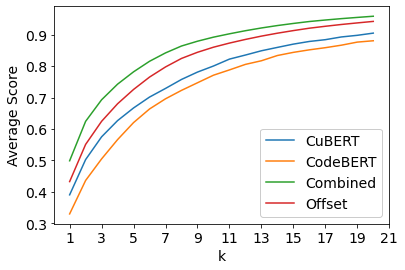

cubert 65.7 82.9 96.0 99.2
codebert 57.1 76.0 93.0 97.7
offset+keyword 68.6 89.2 98.2 99.6
offset 65.0 85.8 96.5 98.8
keyword 23.8 33.8 37.8 38.1


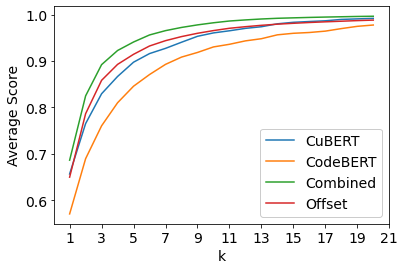

cubert 27.2 41.2 60.1 70.0
codebert 23.3 37.6 56.2 65.8
offset+keyword 23.2 40.8 66.7 80.7
offset 21.0 37.9 65.1 79.9
keyword 6.8 9.9 10.6 10.6


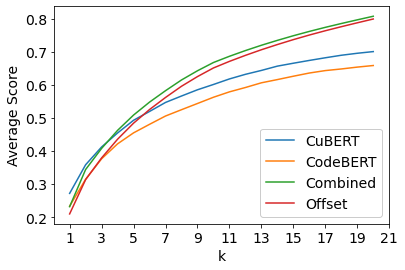

In [28]:
# cubert and codebert on the same graph

with open("../../CodeSyntax/CodeSyntax_python.json", "r") as f:
    dataset = json.load(f)
relns = get_relns(dataset)
include_keyword_baseline = False

for metric in ["first", 'any', 'last']:
    for partition in ["test"]: # valid or test
        with open("data/scores/cubert_python_full_topk_scores_"+partition+"_"+ metric +"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_"+partition+"_"+ metric +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)
        
#         with open("data/scores/codebert_python_full_topk_scores_roberta_"+partition+"_"+ metric +"_common.pkl", "rb") as f:
#             roberta_scores = pickle.load(f)
#         roberta_reln_avg, roberta_cat_avg = get_avg(roberta_scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_offset_"+partition+"_" + metric + "_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_keywords_"+partition+"_" + metric + "_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)


        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
#         print("roberta", round(roberta_reln_avg[1]*100, 1), round(roberta_reln_avg[3]*100, 1), round(roberta_reln_avg[10]*100, 1), round(roberta_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))
    #     for  in [1,3,10,20]:
    #         print("k="+str(i)+", attention", reln_avg[i],"offset+keyword", scores_topk_offset_keyword[i], 
    #               "offset", scores_topk_offset[i], "keyword", scores_topk_keyword[i])
    #     print("offset", scores_topk_offset)

        plt.rcParams["figure.figsize"] = (8,5)
        x = [k for k in range(1, 21)]
        plt.plot(x, reln_avg[1:21], label = "CuBERT")  # attention score
        plt.plot(x, codebert_reln_avg[1:21], label = "CodeBERT") 
#         plt.plot(x, roberta_reln_avg[1:21], label = "roberta") 

        plt.plot(x, scores_topk_offset_keyword[1:21],  label = "Combined")
        plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")
        if include_keyword_baseline:
            plt.plot(x, scores_topk_keyword[1:21],  label = "Keyword")

        plt.xticks(range(1,22, 2))
        plt.xlabel("k")
        plt.ylabel("Average Score")
#         plt.title("Python Scores on " +partition + " set ("+metric+"-token Metric)")
        plt.legend(framealpha=1, frameon=True, loc='lower right')
        if include_keyword_baseline:
            plt.ylim([0, 1.1])
        fig = plt.gcf()
        fig.set_size_inches(6., 4)
        fig.savefig("../../data/figures/python_" +partition + "_" + metric+".pdf", bbox_inches='tight')
        plt.show()

In [29]:
for metric in ["first", 'any', 'last']:
    for partition in ["test"]:
        print(metric)
        with open("data/scores/cubert_python_full_topk_scores_"+partition+"_"+ metric +"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_"+partition+"_"+ metric +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_offset_"+partition+"_" + metric + "_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_keywords_"+partition+"_" + metric + "_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)


        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))
        
        print_attn_table(1, relns, scores)
        print_attn_baseline_table(1, relns, scores, reln_scores_topk_offset, diff=True)

first
cubert 39.1 57.5 80.0 90.5
codebert 33.0 50.5 77.1 88.1
offset+keyword 49.9 69.3 89.2 95.8
offset 43.3 62.4 86.0 94.2
keyword 16.6 23.6 25.5 25.7
relationship		  accuracy	layer	head
===================Control Flow==================
If:body->orelse               0.292	6	5
If:if->body                   0.315	17	3
If:if->else                   0.927	16	1
If:if->test                   0.988	12	0
If:test->body                 0.163	16	6
If:test->orelse               0.075	16	1
For:for->body                 0.304	17	3
For:for->iter                 0.341	16	4
For:for->target               0.994	12	0
For:iter->body                0.117	14	6
For:target->body              0.264	6	11
For:target->iter              0.583	14	9
While:test->body              0.162	17	3
While:while->body             0.221	17	3
While:while->test             0.993	5	13
Try:body->finalbody           0.205	15	8
Try:body->handler             0.391	6	11
Try:body->orelse              0.105	17	9
Try:handler->finalbody   

cubert 66.6 84.5 96.6 99.3
codebert 58.3 77.9 94.1 98.6
offset+keyword 72.1 90.7 98.8 99.7
offset 66.8 87.4 97.1 98.9
keyword 30.5 40.8 44.9 45.2


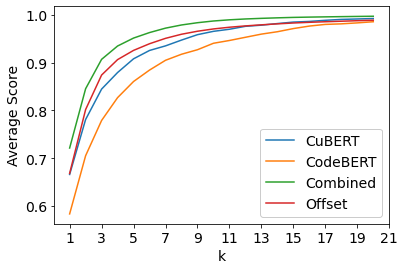

cubert 30.3 47.1 69.7 79.0
codebert 24.6 41.2 62.8 75.0
offset+keyword 27.5 42.7 66.6 80.1
offset 20.2 36.6 64.4 79.3
keyword 12.1 13.8 13.9 13.9


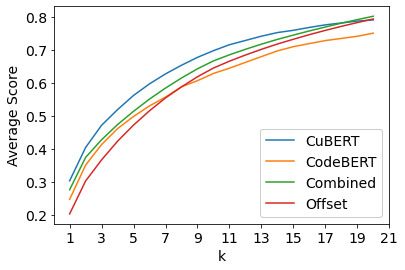

In [30]:
# with new lines added
add_new_lines=True
include_keyword_baseline = False

dataset_file_name = "CodeSyntax_python"
output_file_name = "" if not add_new_lines else  "_with_new_lines"
if add_new_lines:
    dataset_file_name += "_with_new_lines"
with open("../../CodeSyntax/"+dataset_file_name+".json", 'r') as f:
    dataset = json.load(f)
relns = get_relns(dataset)
metrics = ["first", 'any', 'last'] if not add_new_lines else ['any', 'last']

for metric in metrics:
    for partition in ["test"]: # valid or test
        with open("data/scores/cubert_python_full_topk_scores_"+partition+"_"+ metric+output_file_name +"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_"+partition+"_"+ metric+output_file_name +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_offset_"+partition+"_" + metric+output_file_name + "_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/codebert_python_full_topk_scores_keywords_"+partition+"_" + metric+output_file_name + "_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)


        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))
    #     for  in [1,3,10,20]:
    #         print("k="+str(i)+", attention", reln_avg[i],"offset+keyword", scores_topk_offset_keyword[i], 
    #               "offset", scores_topk_offset[i], "keyword", scores_topk_keyword[i])
    #     print("offset", scores_topk_offset)

        plt.rcParams["figure.figsize"] = (8,5)
        x = [k for k in range(1, 21)]
        plt.plot(x, reln_avg[1:21], label = "CuBERT")  # attention score
        plt.plot(x, codebert_reln_avg[1:21], label = "CodeBERT") 

        plt.plot(x, scores_topk_offset_keyword[1:21],  label = "Combined")
        plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")
        if include_keyword_baseline:
            plt.plot(x, scores_topk_keyword[1:21],  label = "Keyword")

        plt.xticks(range(1,22, 2))
        plt.xlabel("k")
        plt.ylabel("Average Score")
#         plt.title("Python Scores on " +partition + " set ("+metric+"-token Metric) (With New Lines Added)")
        plt.legend(framealpha=1, frameon=True, loc='lower right')
        if include_keyword_baseline:
            plt.ylim([0, 1.1])
        fig = plt.gcf()
        fig.set_size_inches(6., 4)
        fig.savefig("../../data/figures/python_" +partition + "_" + metric+"_with_new_line.pdf", bbox_inches='tight')
        plt.show()

# java results

cubert 39.7 59.8 80.0 90.2
codebert 36.3 57.1 78.3 88.8
offset+keyword 60.4 77.2 90.0 96.1
offset 52.7 71.5 87.1 94.3
keyword 22.4 27.3 30.2 30.6


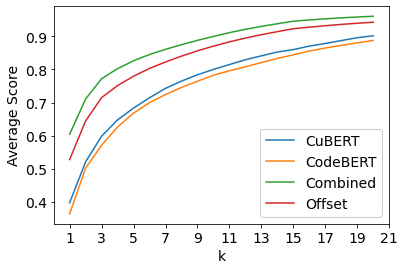

cubert 72.1 87.4 97.5 99.5
codebert 62.7 81.1 93.9 97.6
offset+keyword 75.7 90.0 98.2 99.6
offset 69.4 86.5 96.8 99.0
keyword 40.9 44.9 46.7 47.0


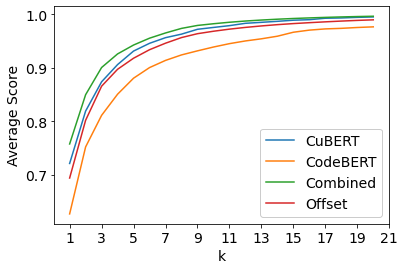

cubert 39.7 63.3 86.3 94.4
codebert 27.5 45.0 67.2 81.8
offset+keyword 37.5 53.5 70.2 80.4
offset 29.5 46.9 67.2 79.6
keyword 13.9 15.3 15.4 15.4


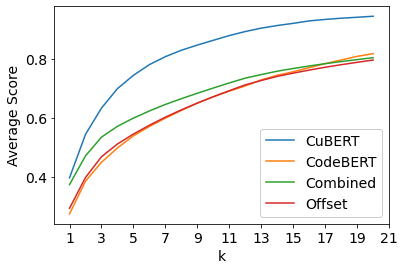

In [21]:
with open("../../CodeSyntax/CodeSyntax_java.json", "r") as f:
    dataset = json.load(f)
relns = get_relns(dataset)
categories = {'Control Flow': ['If', 'For', 'While', 'Try', "Do", "Switch"],
        'Expressions': [  'InfixExpr', 'Call', 'IfExp', 'Attribute', "InstanceofExpr"], 
        'Expr-Subscripting': ['Subscript'],
        'Statements': ['Assign'],
#         'Statements': ['Assign', "LabeledStatement"],
        'Vague': ['children']
        }
Skip_semicolon = False
add_semicolon_to_keywords = True
use_both_offset_and_keywords_in_baselines = False # if it's false, we use max(offset baseline, keyword baseline) for each relation
include_keyword_baseline = False

output_filename=""
attn_output_filename = ""

if Skip_semicolon:
    output_filename="_skip_semicolon" 
    attn_output_filename="_skip_semicolon" 
elif add_semicolon_to_keywords:
    output_filename="_semicolon_in_keywords" 


for metric in ["first", 'any', 'last']:
    for partition in ["test"]: # valid or test
        with open("data/scores/cubert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename+"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)
        
#         with open("data/scores/codebert_java_full_topk_scores_roberta_"+partition+"_"+ metric +attn_output_filename +"_common.pkl", "rb") as f:
#             roberta_scores = pickle.load(f)
#         roberta_reln_avg, roberta_cat_avg = get_avg(roberta_scores, relns, max_k=20)

        with open("data/scores/java_full_topk_scores_offset_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/java_full_topk_scores_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        if not use_both_offset_and_keywords_in_baselines:
            scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)
        else:
            with open("data/scores/java_full_topk_scores_offset_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
                reln_scores_topk_offset_keyword = pickle.load(f)
            scores_topk_offset_keyword = get_scores_topk(reln_scores_topk_offset_keyword, max_k=20)

        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), 
              round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
#         print("roberta", round(roberta_reln_avg[1]*100, 1), round(roberta_reln_avg[3]*100, 1), 
#               round(roberta_reln_avg[10]*100, 1), round(roberta_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))
    #     for  in [1,3,10,20]:
    #         print("k="+str(i)+", attention", reln_avg[i],"offset+keyword", scores_topk_offset_keyword[i], 
    #               "offset", scores_topk_offset[i], "keyword", scores_topk_keyword[i])
    #     print("offset", scores_topk_offset)

        plt.rcParams["figure.figsize"] = (8,5)
        x = [k for k in range(1, 21)]
        plt.plot(x, reln_avg[1:21], label = "CuBERT")  # attention score
        plt.plot(x, codebert_reln_avg[1:21], label = "CodeBERT")  # attention score
#         plt.plot(x, roberta_reln_avg[1:21], label = "roberta")  # attention score
        plt.plot(x, scores_topk_offset_keyword[1:21],  label = "Combined")
        plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")
        if include_keyword_baseline:
            plt.plot(x, scores_topk_keyword[1:21],  label = "Keyword")
            plt.ylim([0, 1.1])

        plt.xticks(range(1,22, 2))
        plt.xlabel("k")
        plt.ylabel("Average Score")
#         plt.title("Java "+partition + " set ("+metric+"-token Metric) "+output_filename[1:])
        plt.legend(framealpha=1, frameon=True, loc='lower right');
        
        fig = plt.gcf()
        fig.set_size_inches(6., 4)
        fig.savefig("../../data/figures/java_" +partition + "_" + metric+"_"+output_filename[1:]+".pdf", bbox_inches='tight')
        plt.show()

        # keywords only: 52 keywords
        # offset only: 512 offsets
        # keywords+offset: max of two


In [22]:
Skip_semicolon = False
add_semicolon_to_keywords = True
use_both_offset_and_keywords_in_baselines = False # if it's false, we use max(offset baseline, keyword baseline) for each relation
include_keyword_baseline = False

output_filename=""
attn_output_filename = ""

if Skip_semicolon:
    output_filename="_skip_semicolon" 
    attn_output_filename="_skip_semicolon" 
elif add_semicolon_to_keywords:
    output_filename="_semicolon_in_keywords" 

for metric in ["first", 'any', 'last']:
    for partition in ["test"]: # valid or test
        print(metric)
        with open("data/scores/cubert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename+"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)

        with open("data/scores/java_full_topk_scores_offset_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/java_full_topk_scores_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        if not use_both_offset_and_keywords_in_baselines:
            scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)
        else:
            with open("data/scores/java_full_topk_scores_offset_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
                reln_scores_topk_offset_keyword = pickle.load(f)
            scores_topk_offset_keyword = get_scores_topk(reln_scores_topk_offset_keyword, max_k=20)

        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), 
              round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))


        print_attn_table(1, relns, scores)
        print_attn_baseline_table(1, relns, scores, reln_scores_topk_offset, diff=True)

first
cubert 39.7 59.8 80.0 90.2
codebert 36.3 57.1 78.3 88.8
offset+keyword 60.4 77.2 90.0 96.1
offset 52.7 71.5 87.1 94.3
keyword 22.4 27.3 30.2 30.6
relationship		  accuracy	layer	head
===================Control Flow==================
If:body->orelse               0.287	8	9
If:if->body                   0.488	18	15
If:if->else                   0.87 	8	9
If:if->test                   0.582	9	0
If:test->body                 0.113	8	9
If:test->orelse               0.026	18	14
For:for->body                 0.161	15	4
For:for->initializers         0.975	2	7
For:for->test                 0.105	15	14
For:for->updaters             0.362	5	13
For:initializers->body        0.21 	19	15
For:initializers->test        0.151	5	2
For:initializers->updaters    0.398	5	13
For:test->body                0.139	18	15
For:test->updaters            0.76 	23	9
For:updaters->body            0.194	18	15
While:test->body              0.094	6	14
While:while->body             0.132	15	4
While:while->test       

cubert 72.0 86.6 97.0 99.2
codebert 63.0 81.3 94.3 97.8
offset+keyword 72.2 88.8 98.0 99.6
offset 68.3 86.0 96.6 98.9
keyword 32.3 39.2 42.2 42.7


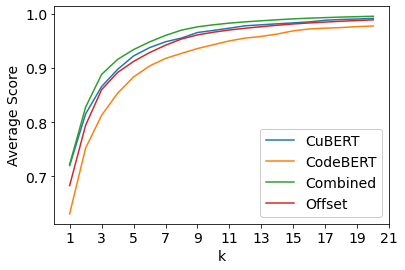

cubert 33.7 49.4 68.3 79.3
codebert 27.7 44.0 62.9 74.3
offset+keyword 32.4 49.9 70.2 81.1
offset 29.8 47.7 68.8 80.4
keyword 9.3 12.8 13.5 13.5


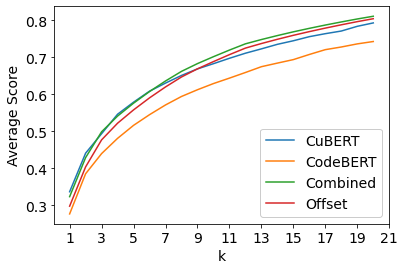

In [27]:
# with new lines added
categories = {'Control Flow': ['If', 'For', 'While', 'Try', "Do", "Switch"],
        'Expressions': [  'InfixExpr', 'Call', 'IfExp', 'Attribute', "InstanceofExpr"], 
        'Expr-Subscripting': ['Subscript'],
        'Statements': ['Assign'],
#         'Statements': ['Assign', "LabeledStatement"],
        'Vague': ['children']
        }
Skip_semicolon = True
add_new_lines=False
add_semicolon_to_keywords = False if Skip_semicolon else True
use_both_offset_and_keywords_in_baselines = False # if it's false, we use max(offset baseline, keyword baseline) for each relation
include_keyword_baseline = False

output_filename=""
attn_output_filename = ""

dataset_file_name = "CodeSyntax_java"
if Skip_semicolon:
    output_filename="_skip_semicolon" 
    attn_output_filename="_skip_semicolon" 
if add_new_lines:
    dataset_file_name += "_with_new_lines"
    output_filename ="_with_new_lines"
    attn_output_filename="_with_new_lines" 
if add_semicolon_to_keywords:
    output_filename+="_semicolon_in_keywords" 

with open("../../CodeSyntax/"+dataset_file_name+".json", 'r') as f:
    dataset = json.load(f)
relns = get_relns(dataset)

for metric in ['any', 'last']:
    for partition in ["test"]:
        with open("data/scores/cubert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename+"_common.pkl", "rb") as f:
            scores = pickle.load(f)
        reln_avg, cat_avg = get_avg(scores, relns, max_k=20)

        with open("data/scores/codebert_java_full_topk_scores_"+partition+"_"+ metric +attn_output_filename +"_common.pkl", "rb") as f:
            codebert_scores = pickle.load(f)
        codebert_reln_avg, codebert_cat_avg = get_avg(codebert_scores, relns, max_k=20)

        with open("data/scores/codebert_java_full_topk_scores_offset_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_offset = pickle.load(f)
        scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

        with open("data/scores/codebert_java_full_topk_scores_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
            reln_scores_topk_keyword = pickle.load(f)
        scores_topk_keyword = get_scores_topk(reln_scores_topk_keyword, max_k=20)

        if not use_both_offset_and_keywords_in_baselines:
            scores_topk_offset_keyword = get_scores_topk_max_of_two(reln_scores_topk_offset, reln_scores_topk_keyword, max_k=20)
        else:
            with open("data/scores/java_full_topk_scores_offset_keywords_"+partition+"_" + metric + output_filename+"_common.pkl", "rb") as f:
                reln_scores_topk_offset_keyword = pickle.load(f)
            scores_topk_offset_keyword = get_scores_topk(reln_scores_topk_offset_keyword, max_k=20)

        print("cubert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
        print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), 
              round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
        print("offset+keyword", round(scores_topk_offset_keyword[1]*100, 1), round(scores_topk_offset_keyword[3]*100, 1), 
              round(scores_topk_offset_keyword[10]*100, 1), round(scores_topk_offset_keyword[20]*100, 1))
        print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                           round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))
        print("keyword", round(scores_topk_keyword[1]*100, 1), round(scores_topk_keyword[3]*100, 1), 
                                                             round(scores_topk_keyword[10]*100, 1), round(scores_topk_keyword[20]*100, 1))
    #     for  in [1,3,10,20]:
    #         print("k="+str(i)+", attention", reln_avg[i],"offset+keyword", scores_topk_offset_keyword[i], 
    #               "offset", scores_topk_offset[i], "keyword", scores_topk_keyword[i])
    #     print("offset", scores_topk_offset)

        plt.rcParams["figure.figsize"] = (8,5)
        x = [k for k in range(1, 21)]
        plt.plot(x, reln_avg[1:21], label = "CuBERT")  # attention score
        plt.plot(x, codebert_reln_avg[1:21], label = "CodeBERT")  # attention score

        plt.plot(x, scores_topk_offset_keyword[1:21],  label = "Combined")
        plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")
        if include_keyword_baseline:
            plt.plot(x, scores_topk_keyword[1:21],  label = "Keyword")
            plt.ylim([0, 1.1])

        plt.xticks(range(1,22, 2))
        plt.xlabel("k")
        plt.ylabel("Average Score")
#         plt.title("Java "+partition + " set ("+metric+"-token Metric) "+output_filename[1:])
        plt.legend(framealpha=1, frameon=True, loc='lower right');
        
        fig = plt.gcf()
        fig.set_size_inches(6., 4)
        fig.savefig("../../data/figures/java_" +partition + "_" + metric+"_"+output_filename[1:]+".pdf", bbox_inches='tight')
        plt.show()

        # keywords only: 52 keywords
        # offset only: 512 offsets
        # keywords+offset: max of two


# generate tables

In [11]:
with open("../../CodeSyntax/CodeSyntax_python.json", "r") as f:
    dataset = json.load(f)
relns = get_relns(dataset)
with open("data/scores/cubert_python_full_topk_scores_test_first_common.pkl", "rb") as f:
    scores = pickle.load(f)
    reln_avg, cat_avg = get_avg(scores, relns, max_k=20)
        
print_attn_table(1, relns, scores)

relationship		  accuracy	layer	head
===================Control Flow==================
If:body->orelse               0.292	6	5
If:if->body                   0.315	17	3
If:if->else                   0.927	16	1
If:if->test                   0.988	12	0
If:test->body                 0.163	16	6
If:test->orelse               0.075	16	1
For:for->body                 0.304	17	3
For:for->iter                 0.341	16	4
For:for->target               0.994	12	0
For:iter->body                0.117	14	6
For:target->body              0.264	6	11
For:target->iter              0.583	14	9
While:test->body              0.162	17	3
While:while->body             0.221	17	3
While:while->test             0.993	5	13
Try:body->finalbody           0.205	15	8
Try:body->handler             0.391	6	11
Try:body->orelse              0.105	17	9
Try:handler->finalbody        0.083	5	1
Try:handler->orelse           0.132	10	11
===================Expressions===================
BinOp:left->right             0.315	16	4
Bool

In [12]:
categories = {'Control Flow': ['If', 'For', 'While', 'Try', "Do", "Switch"],
        'Expressions': [  'InfixExpr', 'Call', 'IfExp', 'Attribute', "InstanceofExpr"], 
        'Expr-Subscripting': ['Subscript'],
        'Statements': ['Assign'],
#         'Statements': ['Assign', "LabeledStatement"],
        'Vague': ['children']
        }
with open("../../CodeSyntax/CodeSyntax_java.json", "r") as f:
    dataset = json.load(f)
relns = get_relns(dataset)
with open("data/scores/cubert_java_full_topk_scores_test_first_common.pkl", "rb") as f:
    scores = pickle.load(f)
    reln_avg, cat_avg = get_avg(scores, relns, max_k=20)
        
print_attn_table(1, relns, scores)

relationship		  accuracy	layer	head
===================Control Flow==================
If:body->orelse               0.287	8	9
If:if->body                   0.488	18	15
If:if->else                   0.87 	8	9
If:if->test                   0.582	9	0
If:test->body                 0.113	8	9
If:test->orelse               0.026	18	14
For:for->body                 0.161	15	4
For:for->initializers         0.975	2	7
For:for->test                 0.105	15	14
For:for->updaters             0.362	5	13
For:initializers->body        0.21 	19	15
For:initializers->test        0.151	5	2
For:initializers->updaters    0.398	5	13
For:test->body                0.139	18	15
For:test->updaters            0.76 	23	9
For:updaters->body            0.194	18	15
While:test->body              0.094	6	14
While:while->body             0.132	15	4
While:while->test             0.419	13	3
Try:body->finalbody           0.07 	6	12
Try:body->handler             0.244	13	5
Try:handler->finalbody        0.195	14	4
Do:body->tes

In [9]:
# convert table to latex format

table = """If:body->orelse               0.691	0.521		16	0.17 
If:if->body                   0.796	0.621		11	0.175
If:if->else                   0.87 	0.07 		15	0.8  
If:if->test                   0.987	0.965		2	0.023
If:test->body                 0.574	0.621		9	-0.047
If:test->orelse               0.423	0.477		27	-0.054
For:for->body                 0.903	0.949		23	-0.047
For:for->initializers         0.994	1.0  		2	-0.006
For:for->test                 0.953	0.895		9	0.058
For:for->updaters             0.536	0.468		11	0.067
For:initializers->body        0.877	0.949		21	-0.072
For:initializers->test        0.745	0.902		7	-0.156
For:initializers->updaters    0.472	0.471		9	0.001
For:test->body                0.923	0.961		14	-0.039
For:test->updaters            0.869	0.536		5	0.333
For:updaters->body            0.968	0.996		9	-0.028
While:test->body              0.874	0.895		15	-0.022
While:while->body             0.914	0.89 		17	0.024
While:while->test             0.988	0.82 		2	0.169
Try:body->finalbody           0.2  	0.13 		37	0.07 
Try:body->handler             0.44 	0.447		25	-0.007
Try:handler->finalbody        0.26 	0.532		20	-0.273
Do:body->test                 0.333	0.267		81	0.067
Do:do->body                   0.933	1.0  		2	-0.067
Do:do->test                   0.333	0.267		81	0.067
Switch:expr->statement        0.966	1.0  		12	-0.034
Switch:switch->expr           0.99 	1.0  		2	-0.01
Switch:switch->statement      1.0  	1.0  		21	0.0  
InfixExpr:left->right         0.582	0.616		2	-0.034
Call:func->args               0.911	0.987		2	-0.076
IfExp:body->orelse            0.595	0.525		2	0.07 
IfExp:test->body              0.259	0.5  		5	-0.241
IfExp:test->orelse            0.459	0.424		10	0.035
Attribute:value->attr         0.812	0.839		2	-0.027
InstanceofExpr:expr->type     0.931	0.919		2	0.011
Subscript:value->slice        0.779	0.788		2	-0.009
Assign:target->value          0.814	0.687		2	0.126
children:parent->child        0.44 	0.424		2	0.016 """

table = [l.split() for l in table.split("\n")]
table = [[l[0], str(round(float(l[1])*100, 1)), str(round(float(l[2])*100,1)), l[3], str(round(float(l[4])*100,1))] for l in table]
table.sort(key=lambda x:-float(x[-1]))
print("\n".join([" & ".join(l)+" \\\\" for l in table]))

If:if->else & 87.0 & 7.0 & 15 & 80.0 \\
For:test->updaters & 86.9 & 53.6 & 5 & 33.3 \\
If:if->body & 79.6 & 62.1 & 11 & 17.5 \\
If:body->orelse & 69.1 & 52.1 & 16 & 17.0 \\
While:while->test & 98.8 & 82.0 & 2 & 16.9 \\
Assign:target->value & 81.4 & 68.7 & 2 & 12.6 \\
Try:body->finalbody & 20.0 & 13.0 & 37 & 7.0 \\
IfExp:body->orelse & 59.5 & 52.5 & 2 & 7.0 \\
For:for->updaters & 53.6 & 46.8 & 11 & 6.7 \\
Do:body->test & 33.3 & 26.7 & 81 & 6.7 \\
Do:do->test & 33.3 & 26.7 & 81 & 6.7 \\
For:for->test & 95.3 & 89.5 & 9 & 5.8 \\
IfExp:test->orelse & 45.9 & 42.4 & 10 & 3.5 \\
While:while->body & 91.4 & 89.0 & 17 & 2.4 \\
If:if->test & 98.7 & 96.5 & 2 & 2.3 \\
children:parent->child & 44.0 & 42.4 & 2 & 1.6 \\
InstanceofExpr:expr->type & 93.1 & 91.9 & 2 & 1.1 \\
For:initializers->updaters & 47.2 & 47.1 & 9 & 0.1 \\
Switch:switch->statement & 100.0 & 100.0 & 21 & 0.0 \\
For:for->initializers & 99.4 & 100.0 & 2 & -0.6 \\
Try:body->handler & 44.0 & 44.7 & 25 & -0.7 \\
Subscript:value->slice & 77

# plot the preview figure in intro

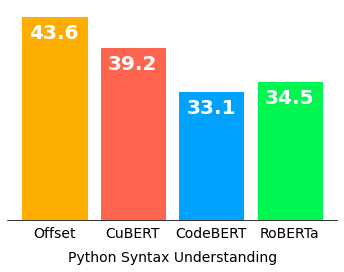

In [8]:
import matplotlib as mpl
mpl.font_manager._rebuild()


fig, ax = plt.subplots(figsize=(5,4))
y_range = [15,100]

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(4),
    height=[x-y_range[0] for x in [43.6,39.2,33.1,34.5]],
    tick_label=["Offset", "CuBERT", "CodeBERT", "RoBERTa"],
    width=0.82
)
bars[0].set_color('#feae00')
bars[1].set_color('#ff644e')
bars[2].set_color('#00a2ff')
bars[3].set_color('#00f651')

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
plt.yticks([])
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 3.1,
      round(bar.get_height()+y_range[0], 1),
      horizontalalignment='center',
      color="#ffffff",
      fontsize='x-large',
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('Python Syntax Understanding', labelpad=10)

fig.tight_layout()
fig.savefig("../../data/figures/preview_PL.pdf", bbox_inches='tight')
plt.show()


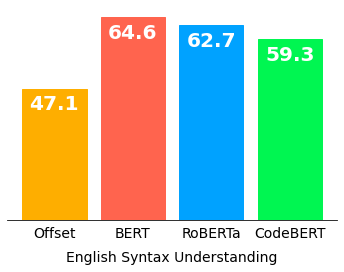

In [8]:
import matplotlib as mpl
# mpl.font_manager._rebuild()


fig, ax = plt.subplots(figsize=(5,4))
y_range = [15,100]

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(4),
    height=[x-y_range[0] for x in [47.1,64.6,62.7,59.3]],
    tick_label=["Offset", "BERT", "RoBERTa", "CodeBERT"],
    width=0.82
)
bars[0].set_color('#feae00')
bars[1].set_color('#ff644e')
bars[2].set_color('#00a2ff')
bars[3].set_color('#00f651')

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
plt.yticks([])
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 5.3,
      round(bar.get_height()+y_range[0], 1),
      horizontalalignment='center',
      color="#ffffff",
      fontsize='x-large',
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('English Syntax Understanding', labelpad=10)
# ax.set_ylabel('Top-1 Score', labelpad=-5)

fig.tight_layout()
fig.savefig("../../data/figures/preview_NL.pdf", bbox_inches='tight')
plt.show()


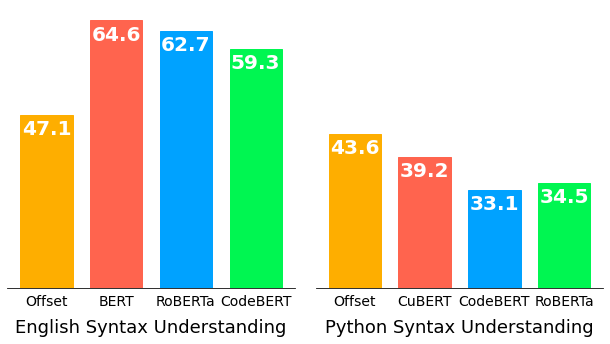

In [55]:
import matplotlib as mpl
# mpl.font_manager._rebuild()


fig, axs = plt.subplots(1, 2, figsize=(8.7, 5), sharey=True)
y_range = [15,100]
bars_list = []

# Save the chart so we can loop through the bars below.
bars_list.append(axs[0].bar(
    x=np.arange(4),
    height=[x-y_range[0] for x in [47.1,64.6,62.7,59.3]],
    tick_label=["Offset", "BERT", "RoBERTa", "CodeBERT"],
    width=0.75
))
bars_list.append(axs[1].bar(
    x=np.arange(4),
    height=[x-y_range[0] for x in [43.6,39.2,33.1,34.5]],
    tick_label=["Offset", "CuBERT", "CodeBERT", "RoBERTa"],
    width=0.75
))

for i, bars in enumerate(bars_list):
    bars[0].set_color('#feae00')
    bars[1].set_color('#ff644e')
    bars[2].set_color('#00a2ff')
    bars[3].set_color('#00f651')

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      axs[i].text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() - 3.7,
          round(bar.get_height()+y_range[0], 1),
          horizontalalignment='center',
          color="#ffffff",
          fontsize='x-large',
          weight='bold'
      )


# Axis formatting.
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    plt.yticks([])
    ax.set_axisbelow(True)


# Add labels and a title.
axs[0].set_xlabel('English Syntax Understanding', labelpad=10, fontsize=18)
axs[1].set_xlabel('Python Syntax Understanding', labelpad=10, fontsize=18)

fig.tight_layout()
fig.savefig("../../data/figures/preview_NL_PL.pdf", bbox_inches='tight')
plt.show()
